# ECE 57000 Assignment 6 Exercise

Your Name: Manish Kumar Krishne Gowda

For this assignment, you will explore various density estimation

---

methods.

## Exercise 1: Density Estimatino in 1D (50/100 points)
In this exercise, you will write code to estimate 1D densities. Specifically, you will write code to estimate a Guassian Density, a Histogram Density, and a Kernel Density.

### Task 1.1: Guassian Distribution (5/100 points)
At first, we start with defining Gaussian PDF. This function will be used througout this assignment.

Gaussian distribution is defined as
$$pdf (x;\mu,\sigma^2) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp \Bigl( - \frac{(x -\mu)^2}{2\sigma^2} \Bigr)$$
with a mean $\mu$ and variance $\sigma^2$.

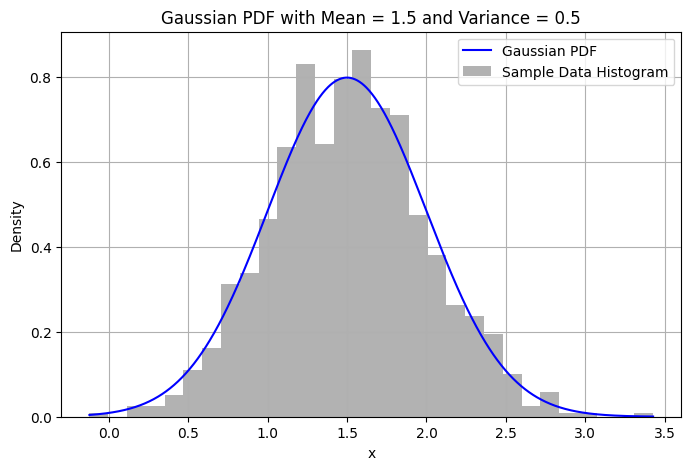

In [41]:
import numpy as np
import matplotlib.pyplot as plt
def gaussian_pdf(x, mean, variance):
    """
    Compute the Gaussian Probability Density Function (PDF).

    Parameters
    ----------
    x : float or array-like
        The point(s) at which to evaluate the Gaussian PDF.
    mean : float
        The mean (center) of the Gaussian distribution.
    variance : float
        The variance (spread) of the Gaussian distribution.

    Returns
    -------
    pdf : float or array-like
        The probability density of the Gaussian distribution evaluated at `x`.
        If `x` is an array, returns an array of the same shape with PDF values.
    """
    ##### Your code here #####
    # You should make the probability density of the Gaussian distribution using numpy.
    # Ensure the variance is positive
    if variance <= 0:
        raise ValueError("Variance must be positive.")

    # Compute the standard deviation
    std_dev = np.sqrt(variance)

    # Compute the Gaussian PDF
    pdf = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)
    ##########################

    return pdf

# Set parameters for the Gaussian distribution
mu = 1.5
sigma = 0.5
variance = sigma ** 2

# Generate sample data
np.random.seed(42)
X = np.random.normal(mu, sigma, size=1000)

# Define range for x values for plotting
x = np.linspace(X.min(), X.max(), 1000)

# Compute the Gaussian PDF for the range of x values
pdf_values = gaussian_pdf(x, mu, variance)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(x, pdf_values, label='Gaussian PDF', color='blue')
plt.hist(X, bins=30, density=True, alpha=0.6, color='gray', label='Sample Data Histogram')
plt.title("Gaussian PDF with Mean = 1.5 and Variance = 0.5")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

### Task 1.2: Guassian Density (15/100 points)
For this assignment, you will estimate a Guassian Density via MLE. As discussed in class, Density Estimation finds a density (PDF/PMF) that represents the data well. The goal is finding a density/distribution function $\hat{P}(x)$ that as close to a ground-truth distribution $P(x)$ as possible. This simplifies to estimating the mean and standard deviation of the data and using these empricial estimates for the Gaussian distribution.


In [42]:
import numpy as np
from sklearn.base import BaseEstimator
np.random.seed(42)
class GaussianDensity(BaseEstimator):
    def fit(self, X, y=None):
        ##### Your code here #####
        # You should estimate the mean and std of the data  and save as self.mean_and self.std
        # (note that X will be shape (n,1) because there is only 1 feature).
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0)
        ##########################
        return self

    def predict_proba(self, X):
        ##### Your code here #####
        # This should return the PDF values for each sample in X (again of shape (n, 1))
        # This should use your self.mean and self.std variables saved from the fit method
        if not hasattr(self, "mean_") or not hasattr(self, "std_"):
            raise ValueError("The model must be fitted before calling predict_proba.")

        # Compute the Gaussian PDF
        pdf_values = (1 / (self.std_ * np.sqrt(2 * np.pi))) * \
                     np.exp(-0.5 * ((X - self.mean_) / self.std_) ** 2)
        pdf_values = pdf_values.ravel()
        ##########################
        return pdf_values  # Output should be of shape (n,), i.e., a 1D array


### Task 1.3: Histogram density (15/100 points)
Now you will implement a histogram density estimate given min, max and number of bins.
The function [`np.searchsorted`](https://numpy.org/doc/stable/reference/generated/numpy.searchsorted.html) may be useful but is not required. Additional instructions are inline in the code template below.

In [43]:
import numpy as np
from sklearn.base import BaseEstimator
np.random.seed(42)
class HistogramDensity(BaseEstimator):
    def __init__(self, n_bins, min_val, max_val):
        self.n_bins = n_bins
        self.min_val = min_val
        self.max_val = max_val

    def fit(self, X, y=None):
        ##### Your code here #####
        # First create equally spaced bin_edges based on min_val, max_val and n_bins
        #  and save as self.bin_edges_
        #  (note the shape of self.bin_edges_ should be (n_bins+1,) )
        # Second, estimate the frequency for each bin based on the input data X
        #  (i.e., the number of training samples that fall into that bin divided
        #  by the total number of samples)
        # Third, using the probability for each bin, compute the density value (i.e., PDF) for
        #  each bin. (Note you will have to account for the width of the bin to ensure
        #  that integrating your density function from min_value to max_value will be 1).
        #  Save the density per bin as self.pdf_per_bin_ which should have the shape (n_bins,)

        # Step 1: Compute equally spaced bin edges
        self.bin_edges_ = np.linspace(self.min_val, self.max_val, self.n_bins + 1)

        # Step 2: Compute histogram (frequency counts) and normalize to probabilities
        hist, _ = np.histogram(X, bins=self.bin_edges_)
        probabilities = hist / len(X)  # Normalize by total number of samples

        # Step 3: Compute PDF for each bin (density = probability / bin width)
        bin_width = self.bin_edges_[1] - self.bin_edges_[0]
        self.pdf_per_bin_ = probabilities / bin_width
        ##########################
        return self

    def predict_proba(self, X):
        ##### Your code here #####
        # You should return the PDF value of the samples X.  This requires finding out which
        #  bin each sample falls into and returning it's corresponding density value
        #  **Importantly, if the value is less than min_value or greater than max_value,
        #    then a pdf value of 0 should be returned.

        if not hasattr(self, "bin_edges_") or not hasattr(self, "pdf_per_bin_"):
            raise ValueError("The model must be fitted before calling predict_proba.")

        # Flatten the input X to ensure it's a 1D array
        X = np.asarray(X).ravel()

        # Step 1: Assign each sample to a bin
        bin_indices = np.digitize(X, self.bin_edges_) - 1  # Bin index starts at 0

        # Step 2: Initialize PDF values with zeros
        pdf_values = np.zeros_like(X, dtype=np.float64)

        # Step 3: Handle valid indices
        valid_mask = (bin_indices >= 0) & (bin_indices < self.n_bins)
        pdf_values[valid_mask] = self.pdf_per_bin_[bin_indices[valid_mask]]
        return pdf_values  # Output should be of shape (n,), i.e., a 1D array
        ##########################

### Task 1.4: Kernel density (15/100 points)
Now you will implement a kernel density estimate (KDE) via a Gaussian kernel given the bandwidth parameter (i.e., the standard deviation of the Gaussian kernel.
Specifically, the Gaussian kernel density is given by:
$$p(x; D) = \frac{1}{n}\sum_{i=1}^n p_{N}(x; \mu = x_i, \sigma=h) $$
where $D=\{x_i\}_{i=1}^n$ is a training dataset of $n$ samples, $p_{N}$ is the Gaussian/normal density function and $h$ is called the bandwidth hyperparameter of the KDE model.
(Note that fitting merely requires saving the training dataset. The saved training data is then used at test time to compute the densities of new samples.)

In [44]:
import numpy as np
from sklearn.base import BaseEstimator
np.random.seed(42)
class KernelDensity(BaseEstimator):
    def __init__(self, bandwidth):
        self.bandwidth = bandwidth

    def fit(self, X, y=None):
        ##### Your code here #####
        # Save the training data in self.X_train_
        self.X_train_ = np.array(X).ravel()  # Ensure 1D array for easier computation
        ##########################
        return self

    def predict_proba(self, X):
        ##### Your code here #####
        # You should return the KDE PDF value of the samples X.
        #  Note that the mean above is over the TRAINING samples, not the test samples
        #  so you should use the samples saved by the fit method.
        # Estimate KDE PDF values for samples in X

        if not hasattr(self, "X_train_"):
            raise ValueError("The model must be fitted before calling predict_proba.")

        # Convert X to a 1D array
        X = np.array(X).ravel()

        # Kernel function: Gaussian kernel
        def gaussian_kernel(x, xi, bandwidth):
            return np.exp(-0.5 * ((x - xi) / bandwidth) ** 2) / (bandwidth * np.sqrt(2 * np.pi))

        # Compute KDE for each sample in X
        pdf_values = []
        for x in X:
            kernel_values = gaussian_kernel(x, self.X_train_, self.bandwidth)
            pdf_values.append(np.mean(kernel_values))  # Mean over training samples
        pdf_values = np.array(pdf_values)
        ##########################
        return pdf_values  # Output should be of shape (n,), i.e., a 1D array

You must run the testing code below for your density estimators.

(200, 1) (200, 1)
Fitting GaussianDensity model
True, Shape=(1000,) - Is the output the correct shape?
True, Num neg=0 - Are all pdf values >= 0? 
quad_out=0.9999916379946465

Fitting HistogramDensity model
True, Shape=(1000,) - Is the output the correct shape?
True, Num neg=0 - Are all pdf values >= 0? 
quad_out=1.0000260507608278

Fitting KernelDensity model
True, Shape=(1000,) - Is the output the correct shape?
True, Num neg=0 - Are all pdf values >= 0? 
quad_out=1.0



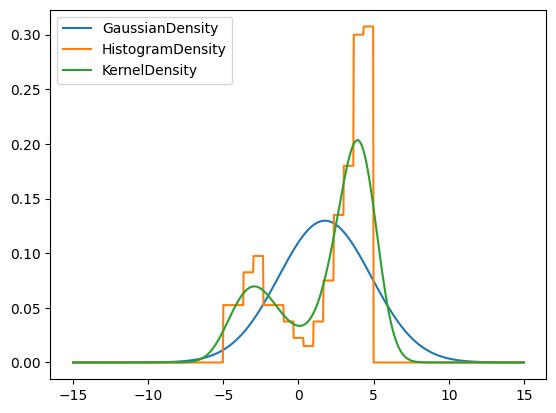

In [45]:
# %pdb on
import scipy.stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Generate some data and split into train and test
np.random.seed(42) # Fix random seed
min_val, max_val = -5, 5
diff = max_val - min_val
X = diff * np.vstack([scipy.stats.beta(6,1).rvs(size=(300,1)), scipy.stats.beta(2,7).rvs(size=(100,1))]) - diff/2
X_train, X_test = train_test_split(X, test_size=0.5, random_state=15)
print(X_train.shape, X_test.shape)

# Loop through models
models = [GaussianDensity(),
          HistogramDensity(n_bins=15, min_val=min_val, max_val=max_val),
          KernelDensity(bandwidth=1)
         ]
for model in models:
    print(f'Fitting {type(model).__name__} model')
    # Fit models
    model.fit(X_train)

    # Sanity checks
    xq = np.linspace(min_val-diff, max_val+diff, num=1000)
    pdf_vals = model.predict_proba(xq.reshape(-1, 1))
    # Adjust shape if model is GaussianDensity and output has two dimensions (N, 1)
    if isinstance(model, GaussianDensity) and len(pdf_vals.shape) > 1 and pdf_vals.shape[1] == 1:
        pdf_vals = pdf_vals.reshape(-1)  # Flatten to shape (N,)
    # Check that right size and >= 0
    print(f'{len(pdf_vals.shape) == 1 and pdf_vals.shape[0] == len(xq)}, Shape={pdf_vals.shape}'
          f' - Is the output the correct shape?')
    print(f'{np.all(pdf_vals>=0)}, Num neg={np.sum(pdf_vals < 0)} - Are all pdf values >= 0? ')

    # Check that integrates to 1 vai approximate numerical integration
    model_pdf = lambda x: model.predict_proba(np.array(x).reshape(1,1))[0]
    quad_out = scipy.integrate.quad(model_pdf, min_val - diff, max_val + diff, limit=100, full_output=True)
    # print(f'{np.abs(quad_out[0] - 1) < 1e-4}, quad_out={quad_out[0]} - Does the PDF integrate to 1? ')
    print(f'quad_out={quad_out[0]}')
    print('')

    # Plot density model
    plt.plot(xq, pdf_vals, label=type(model).__name__)

plt.legend()

## Exercise 2: Gaussian Mixture Model and EM Alogirhtm (50/100 points)
In this exercise, you will implement a Gaussian Mixture Model (GMM) using the Expectation-Maximization (EM) algorithm. Specifically:
- **Create a Ground-Truth GMM**: Define a Gaussian Mixture with specified parameters (e.g., number of components, means, variance, and weight) to serve as the "ground truth."
- **Approximate the GMM Using the EM Algorithm**: Initialize your Gaussian Mixture Model randomly from given data and apply the EM algorithm to approximate the parameters of the GMM based on the generated data.

Creating a ground truth and visualize it.

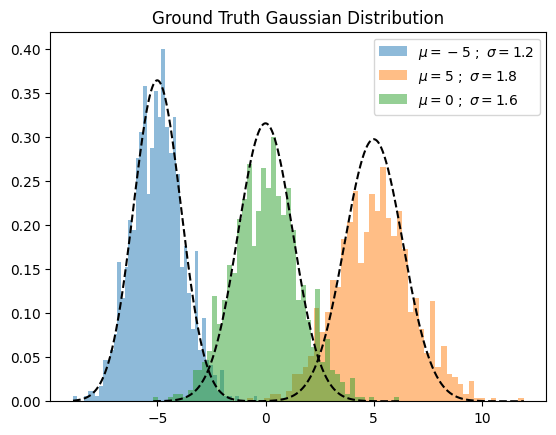

In [46]:
# from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
n_samples = 100
mu1, sigma1 = -5, 1.2
mu2, sigma2 = 5, 1.8
mu3, sigma3 = 0, 1.6

def plot_pdf(mu,sigma,label,alpha=0.5,linestyle='k--',density=True,color='green',use_label=False):
    """
    Plot 1-D Guassian Distribution and its PDF curve.

    Parameters
    ----------
    X : array-like, shape (n_samples,)
        The input data.
    """
    # Create Guassian Distribution data by specifying mean and variance.
    np.random.seed(42)
    X = np.random.normal(mu, sigma, size=1000)

    # Draw histogram of Gaussian Distribution
    if use_label:
        plt.hist(X, bins=50, density=density, alpha=alpha,label=label,color=color)
    else :
        plt.hist(X, bins=50, density=density, alpha=alpha, color=color)

    # Plot the PDF
    x = np.linspace(X.min(), X.max(), 1000)
    y = gaussian_pdf(x, mu, sigma)
    plt.plot(x, y, linestyle)
plot_pdf(mu1,sigma1,label=r"$\mu={} \ ; \ \sigma={}$".format(mu1,sigma1),color='C0',use_label=True)
plot_pdf(mu2,sigma2,label=r"$\mu={} \ ; \ \sigma={}$".format(mu2,sigma2),color='C1',use_label=True)
plot_pdf(mu3,sigma3,label=r"$\mu={} \ ; \ \sigma={}$".format(mu3,sigma3),color='C2',use_label=True)
plt.title("Ground Truth Gaussian Distribution")
plt.legend()
plt.show()


Now we create the data $X$ consist of Gaussian Distributions as a synthetic dataset. However, note that we don’t know which component generated each point in $X$, nor do we know the exact parameters of these Gaussians in practice.

In [47]:

# Create a dataset
np.random.seed(0)
x1 = np.random.normal(loc = mu1, scale = np.sqrt(sigma1), size = n_samples)
x2 = np.random.normal(loc = mu2, scale = np.sqrt(sigma2), size = n_samples)
x3 = np.random.normal(loc = mu3, scale = np.sqrt(sigma3), size = n_samples)

X = np.concatenate((x1,x2,x3))
# Shuffle the order of X
np.random.shuffle(X)
print(X.shape)

(300,)


### Task 2.1: Random Initialization (10/100 points)
In this task, you will initialize mean, covariance, and weight parameters.
1. Mean (μ): Initialize randomly by choosing random $N$ samples from $X$. The chosen data points serve as initial means for each component.
2. Covariance (Σ): Initialize random numbers between 0 and 1 for each component.
3. weight (mixing coefficients) (π): fraction per class refers to the likelihood that a particular data point belongs to each class. In the beginning, this will be equal for all clusters. Assume that we fit a GMM with three components. In this case weight parameter might be set to 1/3 for each component, resulting in a probability distribution of (1/3, 1/3, 1/3).


***Hint***: Use ```np.random.choice``` and ```np.random.random_sample```.

If you define means, variance, and pi in correct order, the result should be
```
means= [-5.38111866  2.92747209  3.46050925]
variances= [0.98394927 0.50901966 0.7871809 ]
pi= [0.33333333 0.33333333 0.33333333]
```

means= [-5.38111866  2.92747209  3.46050925]
variances= [0.98394927 0.50901966 0.7871809 ]
pi= [0.33333333 0.33333333 0.33333333]


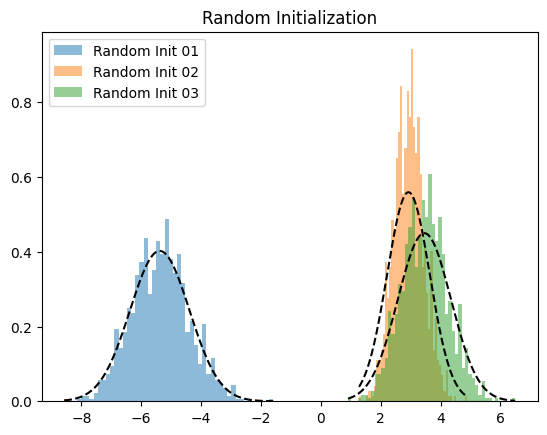

In [48]:
def random_init(X, n_components):
    """
    Initialize means, weights and variance randomly.

    Parameters
    ----------
    X : array-like, shape (n_samples,)
        The input data.
    n_components: integer number
                  The number of Gaussian components.

    Returns
    -------
    means : array-like, shape (n_components,)
        Randomly chosen samples as initial means.
    variances : array-like, shape (n_components,)
        Random float numbers between [0,1] as initial variances.
    pi : array-like, shape (n_components,)
        Initial weight between components.
    """
    ##### Your code here #####
    # You should estimate choose three random data points in data to serves as 'means',
    # three random float numbers between [0,1] as 'variances',
    # and initial weight 'pi' giving equal weight to each component.
    # Randomly select initial means from the data
    means = np.random.choice(X, size=n_components, replace=True)

    # Generate random variances between 0 and 1
    variances = np.random.random_sample(n_components)

    # Assign equal weights to each component
    pi = np.ones(n_components) / n_components

    ##########################
    print('means=',means)
    print('variances=',variances)
    print('pi=',pi)
    plot_pdf(means[0],variances[0],'Random Init 01',color='C0',use_label=True)
    plot_pdf(means[1],variances[1],'Random Init 02',color='C1',use_label=True)
    plot_pdf(means[2],variances[2],'Random Init 03',color='C2',use_label=True)

    plt.title("Random Initialization")

    plt.legend()
    plt.show()

    return means,variances,pi
np.random.seed(24)
n_compenents = 3
means,variances,pi = random_init(X, n_compenents)

### Task 2.2: Expectation Step (E step) (20/100 points)
For each data point $x_i$, calculate the probability that the data point belongs to cluster ($k$) using the below equation. $k$ is the number of distributions we are supposed to find.
$$ r_{i,k} = \frac{\pi_k N (x_i \vert \mu_k, {\scriptsize\sum}_c )}{\sum_{k=1}^K\pi_k N (x_i \vert \mu_k, {\scriptsize\sum}_k )}$$
where $\pi_c$ is the mixing coefficient (weight) for the Guassian distribution $c$, which was initialized in the previous stage. $N(x\vert\mu,{\scriptsize\sum})$ descreibes the probability density function (PDF) of a Gaussian distribution with mean $\mu$ and covariance Σ with respect to data point $x$.

In [49]:

def step_expectation(X,n_components,means,variances,pi):
    """
    E Step - Calculate the responsibility matrix.

    Parameters
    ----------
    X : array-like, shape (n_samples,)
        The data.
    n_components : int
        The number of clusters.
    means : array-like, shape (n_components,)
        The means of each mixture component.
    variances : array-like, shape (n_components,)
        The variances of each mixture component.
    pi : array-like, shape (n_components,)
        The mixing weights of each component.

    Returns
    -------
    r : array-like, shape (n_components, n_samples)
        The responsibility matrix, where responsibilities[j, i] is the responsibility of component j for data point i.
    """
    n_samples = len(X)
    r = np.zeros((n_components, n_samples))

    ##### Your code here #####
    # Calculate responsibilities for each component. Hint: Utilize 'gaussian_pdf' defined previously.
    # After that, normalize responsibilities to sum to 1 for each sample
    # Calculate responsibilities for each component
    for k in range(n_components):
        r[k, :] = pi[k] * gaussian_pdf(X, means[k], variances[k])

    # Normalize responsibilities to sum to 1 for each sample
    r_sum = np.sum(r, axis=0, keepdims=True)  # Sum over components for each sample
    r = r / r_sum  # Normalize

    ##########################
    return r
# Test Expectatino Step
r = step_expectation(X,n_compenents,means,variances,pi)


# Check if any summation values deviate from 1
responsibility_sum = np.sum(r, axis=0)
non_one_sums = np.isclose(responsibility_sum, 1, atol=1e-6)  # Use a small tolerance for floating-point precision
print('Summation of responsibility:', responsibility_sum)
print('Shape of responsibility:', r.shape) # It should be (3,300)
if not np.all(non_one_sums):
    print("Warning: Summation of responsibility includes non-one values.")
    print("Non-one summation values:", responsibility_sum[~non_one_sums])
else:
    print("All summation values are approximately equal to 1.")

Summation of responsibility: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Shape of responsibility: (3, 300)
All summation values ar

### Task 2.3: Maximization Step (M step) (20/100 points)
In this step, the algorithm uses the responsibilities of the Gaussian distributions (computed in the E-step) to update the estimates of the model's parameters.

The M-step updates the estimates of the parameters as follows:    
- $\pi_k = \frac{1}{N} \sum_{i=1}^N r_{ik} = \frac{N_k}{N}$ with $N_k = \sum_{i=1}^N r_{ik}$.   
- $\mu_k =  \frac{1}{N_k} \sum_{i=1}^N r_{ik} x_i$.  
- $\sum_k =  \frac{1}{N_k} \sum_{i=1}^N r_{ik} (x_i - \mu_k)(x_i - \mu_k)^T$.  

In [50]:
def step_maximization(X,r):
    """
    M Step - Update parameters based on responsibilities.

    Parameters
    ----------
    X : array-like, shape (n_samples,)
        The data.
    r : array-like, shape (n_components, n_samples)
        The responsibility matrix from the E-step.

    Returns
    -------
    means : array-like, shape (n_components,)
        Updated means of each mixture component.
    variances : array-like, shape (n_components,)
        Updated variances of each mixture component.
    pi : array-like, shape (n_components,)
        Updated mixing weights of each component.
    """
    n_components, n_samples = r.shape

    # # Initialize mean, variance, and pi.
    means = np.zeros(n_components)
    variances = np.zeros(n_components)
    pi = np.zeros(n_components)

    ##### Your code here #####
    # Total responsibility for each component
    N_k = np.sum(r, axis=1)  # Shape: (n_components,)

    # Update pi
    pi = N_k / n_samples  # Mixing weights

    # Update means
    for k in range(n_components):
        means[k] = np.sum(r[k, :] * X) / N_k[k]

    # Update variances
    for k in range(n_components):
        variances[k] = np.sum(r[k, :] * (X - means[k])**2) / N_k[k]

    ##########################
    return means, variances, pi


In [51]:

# Define plotting function for GMM
def plot_GMM(means,variances):
    x = np.linspace(X.min(), X.max(), 1000)
    y1 = gaussian_pdf(x, mu1, sigma1)
    y2 = gaussian_pdf(x, mu2, sigma2)
    y3 = gaussian_pdf(x, mu3, sigma3)
    plt.plot(x, y1, 'r--')
    plt.plot(x, y2, 'r--')
    plt.plot(x, y3, 'r--')
    color_gen = (x for x in ['C0','C1','C2'])
    for mu,sigma in zip(means,variances):
        plot_pdf(mu,sigma,alpha=0.5,label='d',color=next(color_gen),use_label=False)
    plt.plot([], [], 'r--', label='Ground Truth')  # Red dashed line for Ground Truth
    plt.plot([], [], 'k--', label='Gaussian Mixture Model')           # Black dashed line for GMM
    # Show legend and plot
    plt.legend()
    plt.show()


You must run the testing code below for your GMM and EM algorithm.

After first step, the result should be

```
means= [-4.23311078  1.80177309  3.64918194]
variances= [0.98394927 0.50901966 0.7871809 ]
pi= [0.41997062 0.16526334 0.41476604]
```

After First Step

means= [-4.23311078  1.80177309  3.64918194]
variances= [0.98394927 0.50901966 0.7871809 ]
pi= [0.41997062 0.16526334 0.41476604]


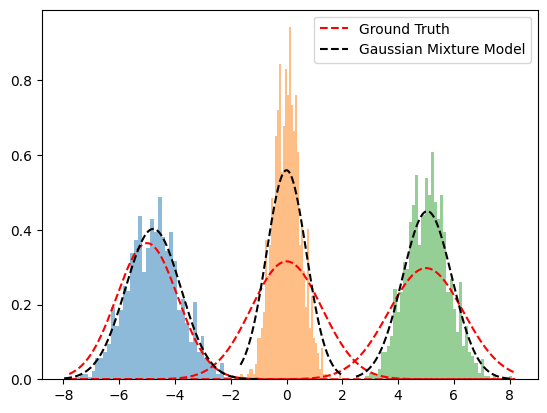

In [52]:
n_steps=50
# Run GMM for n_steps
for step in range(n_steps):
    r = step_expectation(X,n_compenents,means,variances,pi)
    means,varaiances,pi = step_maximization(X, r)
    if step==0:
        print("After First Step\n")
        print('means=',means)
        print('variances=',variances)
        print('pi=',pi)
plot_GMM(means,variances)